# Modelado con LSTM usando landmarks de MediaPipe

Este notebook carga los puntos clave (landmarks) extraídos en el preprocesamiento y entrena un modelo LSTM para clasificar los números en lenguaje de señas.

In [36]:
# Librerías necesarias
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import joblib

## 1. Cargar los landmarks y preparar los datos

In [37]:
# Ruta al archivo CSV de landmarks
landmarks_csv = os.path.join("..", "preprocessed_numbers", "landmarks.csv")
if not os.path.exists(landmarks_csv):
	raise FileNotFoundError(f"El archivo {landmarks_csv} no existe. Verifica la ruta y que el archivo haya sido generado en el preprocesamiento.")
df = pd.read_csv(landmarks_csv)

df = df[df["class"].isin([str(i) for i in range(11)])].reset_index(drop=True)

# Extraer X (landmarks) y y (clase)
X = df[[f"lm_{i}" for i in range(63)]].values.astype(np.float32)
y = df["class"].values

# Codificar etiquetas
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Para LSTM: reshape a (samples, timesteps, features)
# MediaPipe Hands tiene 21 puntos, cada uno con (x, y, z)
X_lstm = X.reshape(-1, 21, 3)
print("Shape X_lstm:", X_lstm.shape)
print("Shape y_enc:", y_enc.shape)

Shape X_lstm: (6113, 21, 3)
Shape y_enc: (6113,)


## 2. Dividir en entrenamiento y validación

In [38]:
X_train, X_val, y_train, y_val = train_test_split(
    X_lstm, y_enc, test_size=0.15, random_state=42, stratify=y_enc
)
print("Train:", X_train.shape, "Val:", X_val.shape)

Train: (5196, 21, 3) Val: (917, 21, 3)


## 3. Construir el modelo LSTM

### Grid Search de hiperparámetros

Probamos diferentes combinaciones de hiperparámetros para el modelo LSTM y seleccionamos la mejor según la precisión en validación.

In [39]:
def build_lstm_model(units1, units2, dense_units, input_shape, num_classes, optimizer, loss):
    model = keras.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.LSTM(units1, return_sequences=True),
        keras.layers.LSTM(units2),
        keras.layers.Dense(dense_units, activation="relu"),
        keras.layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=["accuracy"]
    )
    return model

# Definir el espacio de búsqueda
param_grid = {
    "units1": [32, 64],
    "units2": [16, 32],
    "dense_units": [16, 32],
    "optimizer": ["adam", "rmsprop"],
    "loss": ["sparse_categorical_crossentropy", "categorical_crossentropy"]
}

results = []
num_classes = len(le.classes_)
input_shape = (21, 3)

# Ajuste para categorical_crossentropy: one-hot encoding
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)

for units1, units2, dense_units, optimizer, loss in product(
    param_grid["units1"], param_grid["units2"], param_grid["dense_units"],
    param_grid["optimizer"], param_grid["loss"]
):
    model = build_lstm_model(units1, units2, dense_units, input_shape, num_classes, optimizer, loss)
    callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
    # Seleccionar etiquetas según el tipo de loss
    if loss == "categorical_crossentropy":
        y_train_fit = y_train_cat
        y_val_fit = y_val_cat
    else:
        y_train_fit = y_train
        y_val_fit = y_val
    hist = model.fit(
        X_train, y_train_fit,
        validation_data=(X_val, y_val_fit),
        epochs=20,
        batch_size=32,
        callbacks=callbacks,
        verbose=0
    )
    val_acc = max(hist.history["val_accuracy"])
    results.append({
        "units1": units1,
        "units2": units2,
        "dense_units": dense_units,
        "optimizer": optimizer,
        "loss": loss,
        "val_accuracy": val_acc,
        "history": hist.history
    })
    print(f"units1={units1}, units2={units2}, dense_units={dense_units}, optimizer={optimizer}, loss={loss} -> val_acc={val_acc:.4f}")

# Ordenar resultados por precisión de validación
results = sorted(results, key=lambda x: x["val_accuracy"], reverse=True)
best_params = results[0]
print("Mejores hiperparámetros:", {k: best_params[k] for k in ["units1", "units2", "dense_units", "optimizer", "loss"]})
print("Mejor precisión de validación:", best_params["val_accuracy"])

units1=32, units2=16, dense_units=16, optimizer=adam, loss=sparse_categorical_crossentropy -> val_acc=0.8953
units1=32, units2=16, dense_units=16, optimizer=adam, loss=categorical_crossentropy -> val_acc=0.8790
units1=32, units2=16, dense_units=16, optimizer=adam, loss=categorical_crossentropy -> val_acc=0.8790
units1=32, units2=16, dense_units=16, optimizer=rmsprop, loss=sparse_categorical_crossentropy -> val_acc=0.8582
units1=32, units2=16, dense_units=16, optimizer=rmsprop, loss=sparse_categorical_crossentropy -> val_acc=0.8582
units1=32, units2=16, dense_units=16, optimizer=rmsprop, loss=categorical_crossentropy -> val_acc=0.8342
units1=32, units2=16, dense_units=16, optimizer=rmsprop, loss=categorical_crossentropy -> val_acc=0.8342
units1=32, units2=16, dense_units=32, optimizer=adam, loss=sparse_categorical_crossentropy -> val_acc=0.8757
units1=32, units2=16, dense_units=32, optimizer=adam, loss=sparse_categorical_crossentropy -> val_acc=0.8757
units1=32, units2=16, dense_units=3

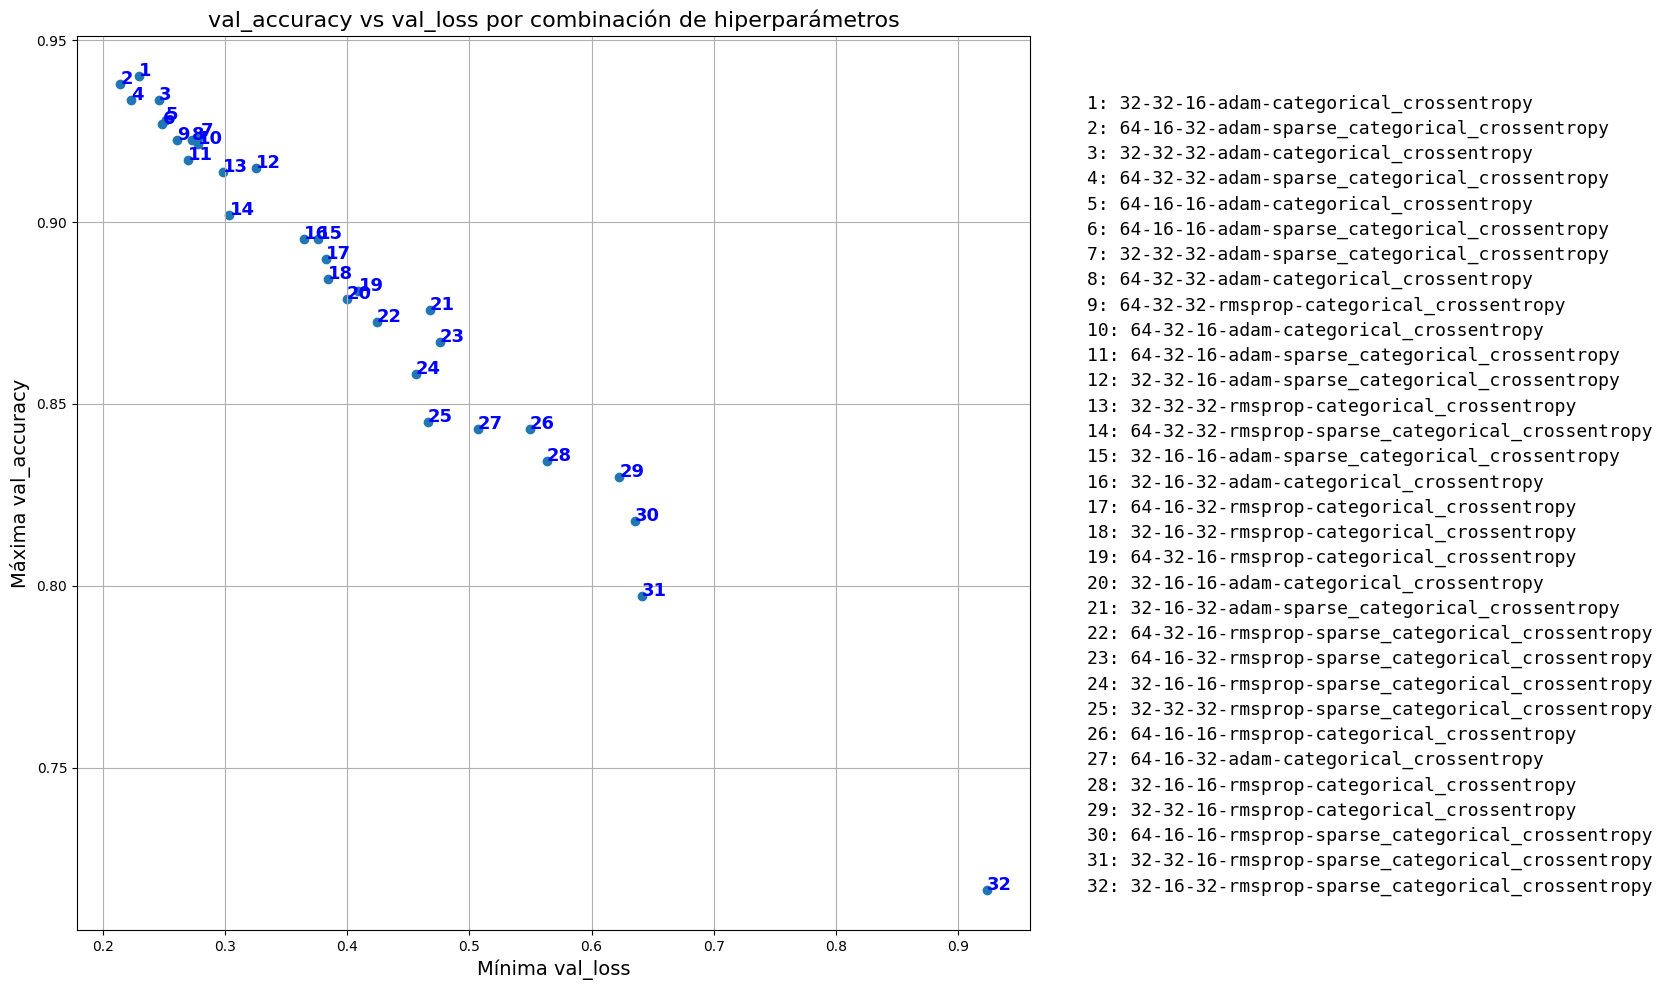

In [40]:
x_loss = [min(r["history"]["val_loss"]) for r in results]
y_acc = [max(r["history"]["val_accuracy"]) for r in results]
ids = list(range(1, len(results) + 1))
labels = [
    f"{r['units1']}-{r['units2']}-{r['dense_units']}-{r['optimizer']}-{r['loss']}"
    for r in results
]

fig, ax = plt.subplots(figsize=(14, 10))
ax.scatter(x_loss, y_acc)

for i, idnum in enumerate(ids):
    ax.annotate(str(idnum), (x_loss[i], y_acc[i]), fontsize=13, weight='bold', color='blue')

ax.set_xlabel("Mínima val_loss", fontsize=14)
ax.set_ylabel("Máxima val_accuracy", fontsize=14)
ax.set_title("val_accuracy vs val_loss por combinación de hiperparámetros", fontsize=16)
ax.grid(True)

# Mostrar la leyenda a la derecha, más cerca y con fuente más grande
legend_text = "\n".join([f"{idnum}: {label}" for idnum, label in zip(ids, labels)])
fig.text(0.78, 0.5, legend_text, fontsize=13, va='center', ha='left', linespacing=1.5, family='monospace')

plt.tight_layout(rect=[0,0,0.75,1])
plt.show()

### Entrenamiento final con la mejor combinación de hiperparámetros

In [41]:
# Entrenar el modelo final con los mejores hiperparámetros
model = build_lstm_model(
    best_params["units1"],
    best_params["units2"],
    best_params["dense_units"],
    input_shape,
    num_classes,
    best_params["optimizer"],
    best_params["loss"]
)
callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
if best_params["loss"] == "categorical_crossentropy":
    y_train_fit = y_train_cat
    y_val_fit = y_val_cat
else:
    y_train_fit = y_train
    y_val_fit = y_val
history = model.fit(
    X_train, y_train_fit,
    validation_data=(X_val, y_val_fit),
    epochs=40,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1739 - loss: 2.2399 - val_accuracy: 0.2933 - val_loss: 2.0311
Epoch 2/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1739 - loss: 2.2399 - val_accuracy: 0.2933 - val_loss: 2.0311
Epoch 2/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3326 - loss: 1.9320 - val_accuracy: 0.4264 - val_loss: 1.6670
Epoch 3/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3326 - loss: 1.9320 - val_accuracy: 0.4264 - val_loss: 1.6670
Epoch 3/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4266 - loss: 1.6187 - val_accuracy: 0.5387 - val_loss: 1.2686
Epoch 4/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4266 - loss: 1.6187 - val_accuracy: 0.5387 - val_loss: 1.2686
Epoch 4/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6147 - loss: 1.1572 - val_accuracy: 0.7448 - val_loss: 0.8372
Epoch 5/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6147 - loss: 1.1572 - val_accuracy: 0.

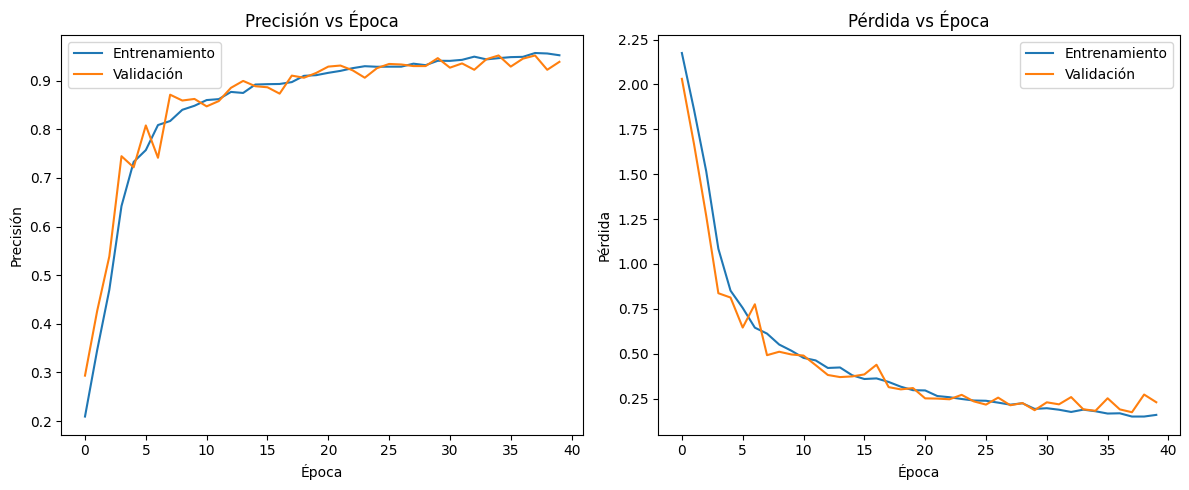

In [42]:
plt.figure(figsize=(12,5))

# Gráfica de precisión
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión vs Época')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida vs Época')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

## 5. Evaluar y guardar el modelo

In [45]:
# Usar el tipo de etiquetas correcto según el loss
if best_params["loss"] == "categorical_crossentropy":
	y_val_eval = y_val_cat
else:
	y_val_eval = y_val

val_loss, val_acc = model.evaluate(X_val, y_val_eval)
print(f"Validación - Loss: {val_loss:.4f}  Acc: {val_acc:.4f}")

# Guardar modelo y codificador de etiquetas en carpeta Modelos
os.makedirs("Modelos", exist_ok=True)
model.save(os.path.join("..","Modelos", "modelo_lstm_landmarks.keras"))
joblib.dump(le, os.path.join("..","Modelos", "label_encoder_landmarks.pkl"))

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9486 - loss: 0.2001
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9486 - loss: 0.2001
Validación - Loss: 0.1745  Acc: 0.9520
Validación - Loss: 0.1745  Acc: 0.9520


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9486 - loss: 0.2001
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9486 - loss: 0.2001
Validación - Loss: 0.1745  Acc: 0.9520
Validación - Loss: 0.1745  Acc: 0.9520


['Modelos\\label_encoder_landmarks.pkl']

¡Listo! El modelo LSTM entrenado y el codificador de etiquetas han sido guardados en la carpeta `Modelos`.